# **Framework for Near-Real Time Sensor-Agnostic Water Classification**

A new image is acquired at T1. Landsat (and potentially Sentinel-2) water masks are aggregated from a period of time T0 (T1-3months). Assuming no significant (TBD) change between T0 and T1 in water extent, it should be possible to identify likely change pixels at the boundary of class distributions if sampled across a representative a large enough area (TBD). Omitting such potential change features enables a significant no. training samples at T1 and these may be used to provide water (+ probability) masks at T1 for all clearsky pixels at T1.

Assumptions
- At least 'somewhat' a complete water mask can be obtained by generating a water summary product for T0
- There is a sufficient area of 'clearsky' within the T1 image
- Class transitions are on a sufficiently limited scale that either
    - (1) they do not need to be omitted and model selection will be robust enough to treat them as outliers, or
    - (2) they can be identified as outliers from the major class distributions using skewness/kurtosis
- 

In [1]:
!pip install salem

In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 
from datetime import datetime
from datetime import timedelta
import pandas as pd
import geopandas as gpd
from shapely import wkt
import rasterio
import rasterio.features
import salem

# sac-specific
from sac_utils.createAOI import create_lat_lon

# dc-specific
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
dc = Datacube()

# ml stuff
from sklearn.ensemble import RandomForestClassifier

import utils_dcal.data_cube_utilities.data_access_api as dc_api
api = dc_api.DataAccessApi()

# dask stuff
import dask.array
import dask
from dask.distributed import Client
client = Client('dask-scheduler.dask.svc.cluster.local:8786')
client

Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 40 Memory: 168.65 GB


# **(0) Set consistent params**

overall aoi and search criteria to assertain datasets across which to run app

In [2]:
viti_levu = "POLYGON((177.47747109686992 -17.376103328077992,178.74364541327617 -17.376103328077992,178.74364541327617 -18.317280451285484,177.47747109686992 -18.317280451285484,177.47747109686992 -17.376103328077992))"
suva = "POLYGON((178.38384316718242 -18.090287234637962,178.49645303046367 -18.090287234637962,178.49645303046367 -18.181641888359497,178.38384316718242 -18.181641888359497,178.38384316718242 -18.090287234637962))"
left = "POLYGON((177.0476310089793 -16.369503321696154,179.1570060089793 -16.369503321696154,179.1570060089793 -19.214508611536765,177.0476310089793 -19.214508611536765,177.0476310089793 -16.369503321696154))"
overall_aoi_wkt = left
overall_aoi_gdf = pd.DataFrame({'geometry':[overall_aoi_wkt]})
overall_aoi_gdf['geometry'] = overall_aoi_gdf['geometry'].apply(wkt.loads)
overall_aoi_gdf['aoi'] = 'aoi'
overall_aoi_gdf = gpd.GeoDataFrame(overall_aoi_gdf, geometry='geometry', crs={"init": "epsg:4326"}) # using {init} important
latitude, longitude = create_lat_lon(overall_aoi_wkt)

product = "s2_esa_sr_granule"
measurements = ["green","red","blue","nir","swir1","swir2", "pixel_qa"]

latitude, longitude

((-19.214508611536765, -16.369503321696154),
 (177.0476310089793, 179.1570060089793))

**find datasets** - *note*: lat lon returns all anti-meridian scenes at that longitude, so need additional filtering here

In [3]:
ds = dc.find_datasets(
    product=product,
    lat=latitude,
    lon=longitude,
#     measurements = measurements,
) 
len(ds), # vars(ds[0])

(1504,)

get **ds footprints & dates** - *note*: ds.extent.wkt doesn't play nice so use yml metadata as already in 4326 wkt

,Date,xmin,xmax,ymin,ymax,id,all_meta,geometry,des
166,2019-11-20 22:19:41,177.945046,178.993869,-19.078459,-18.078345,0ceeca6c-30d1-5aee-8caf-75b1d803f715,Dataset <id=0ceeca6c-30d1-5aee-8caf-75b1d803f7...,POLYGON ((177.9450459818887 -19.07845942999174...,True
168,2019-11-20 22:19:41,177.935926,178.973461,-17.271194,-16.271726,550965de-bd1f-5389-ada2-72c2a8a69758,Dataset <id=550965de-bd1f-5389-ada2-72c2a8a697...,POLYGON ((177.9359264529424 -17.27119367437816...,True


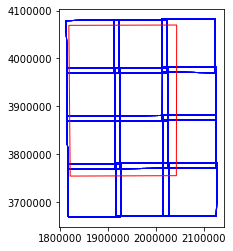

In [4]:
def parsemetaparams(df):
    g = []
    for index, row in df.iterrows():
        g.append(f"Polygon(({row.xmin} {row.ymin}, {row.xmax} {row.ymin}, {row.xmax} {row.ymax}, {row.xmin} {row.ymax}, {row.xmin} {row.ymin}))")
    df['geometry'] = g
    return df
df=pd.DataFrame({
    'Date': [i.metadata.time[0] for i in ds],
    'xmin': [i.metadata.lon[0] for i in ds],
    'xmax': [i.metadata.lon[1] for i in ds],
    'ymin': [i.metadata.lat[0] for i in ds],
    'ymax': [i.metadata.lat[1] for i in ds],
    'id': [i.metadata.id for i in ds],
    'all_meta': [i for i in ds]
})
df = parsemetaparams(df)
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=({"init":"epsg:4326"}))
# repro and intersect to omit potemtial am scenes
a = overall_aoi_gdf.to_crs({"init": "epsg:3460"}) # speed intersect up by repro-ing aoi first
gdf['des'] = gdf.to_crs({"init": "epsg:3460"}).geometry.map(lambda x: x.intersects(a.geometry.any())) # repro and test intersect
gdf = gdf[gdf['des']==True] # subset
gdf = gdf.sort_values(by=['Date'], ascending=False)

# check expected footprints etc.
fig, ax = plt.subplots()
gdf.to_crs({"init": "epsg:3460"}).plot(facecolor="",edgecolor="b", ax=ax);
overall_aoi_gdf.to_crs({"init": "epsg:3460"}).plot(facecolor="",edgecolor="r", ax=ax);
gdf.head(2)

create jobs off **grouped mosaic** datasets & determine **outer extent**

In [5]:
# grab individual acq days
gdf['Day'] = [pd.to_datetime(i).date() for i in gdf.Date.values]
acq_days = np.sort(np.unique(gdf.Day.values))
len(acq_days)

160

In [6]:
# # explore available groups
# for d in acq_days[:]:
#     gr = gdf[gdf['Day'] == d]
#     fig, ax = plt.subplots()
#     overall_aoi_gdf.to_crs({"init": "epsg:3460"}).plot(ax=ax, facecolor='', edgecolor='r')
#     gr.to_crs({"init": "epsg:3460"}).plot(ax=ax, facecolor='', edgecolor='b')
#     ax.set_title(f"Date: {d}")

In [7]:
# select test day
d = acq_days[22]
scenes = gdf[gdf.Day==d]
d

datetime.date(2018, 12, 13)

,Date,xmin,xmax,ymin,ymax,id,all_meta,geometry,des,Day
166,2019-11-20 22:19:41,177.945046,178.993869,-19.078459,-18.078345,0ceeca6c-30d1-5aee-8caf-75b1d803f715,Dataset <id=0ceeca6c-30d1-5aee-8caf-75b1d803f7...,POLYGON ((177.9450459818887 -19.07845942999174...,True,2019-11-20
168,2019-11-20 22:19:41,177.935926,178.973461,-17.271194,-16.271726,550965de-bd1f-5389-ada2-72c2a8a69758,Dataset <id=550965de-bd1f-5389-ada2-72c2a8a697...,POLYGON ((177.9359264529424 -17.27119367437816...,True,2019-11-20


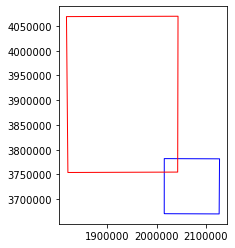

In [8]:
n = 5
# check expected footprints etc.
fig, ax = plt.subplots()
gdf.iloc[[n]].to_crs({"init": "epsg:3460"}).plot(facecolor="",edgecolor="b", ax=ax);
overall_aoi_gdf.to_crs({"init": "epsg:3460"}).plot(facecolor="",edgecolor="r", ax=ax);
gdf.head(2)

In [9]:
# buffer
buffer_path = './FijiCoastalBuffer_shp.shp'
# original scene meta for yaml + export later
original_metadata = gdf.iloc[[n]]['all_meta'].values[0]
# format acquistion date of image being classified
# T = pd.to_datetime(d).date()
T = pd.to_datetime(gdf.iloc[[n]].Date.values[0])
# add a day on to satisfy dc.load time range req
T1 = (str(T),str(T)) # str(pd.to_datetime(T +pd.DateOffset(0)).date())) # no off-set for now
# create T0 range of 90 days prior to acquisition
T0 = (str(pd.to_datetime(T + pd.DateOffset(-91)).date()), str(pd.to_datetime(T + pd.DateOffset(-1)).date()))
# lat and lon taken from image metadate
latitude, longitude = create_lat_lon(str(gdf.iloc[[n]].geometry.values[0]))
# b = scenes.total_bounds
# latitude, longitude = (b[1],b[3]),(b[0],b[2])
# hopefully fiji crs avoids major AM issues
output_crs = "EPSG:32760"
resolution = (-10,10)
ref_channel = 'swir1'

T1_prod = "s2_esa_sr_granule"
T1_measurements = ["green","red","blue","nir","swir1","swir2", "scene_classification"]
T1_vars = ['green','red','blue','nir','swir1','swir2']

print(latitude, longitude)
print(T1, T0)
print(ref_channel)

(-19.97450997949223, -18.9691476451451) (178.899387861451, 179.9594671459378)
('2019-11-20 22:19:41', '2019-11-20 22:19:41') ('2019-08-21', '2019-11-19')
swir1


# **(1) create T0 water mask (T1-3months)**

**load T0 water masks**

In [10]:
product = 'ls8_water_classification'
measurements = ['water']

water_dataset = dc.load(
    product=product,
    time=T0, # quarter prior to T1 
    lat=latitude,
    lon=longitude,
    output_crs=output_crs,
    resolution=resolution,
    measurements = measurements,
    group_by='solar_day',
    dask_chunks={
        #'time': 1,
        'x': 1000,
        'y': 1000,
    }
)
water_dataset

<xarray.Dataset>
Dimensions:  (time: 3, x: 11292, y: 11291)
Coordinates:
  * time     (time) datetime64[ns] 2019-08-25T22:07:12 ... 2019-09-10T22:07:16
  * y        (y) float64 7.902e+06 7.901e+06 7.901e+06 ... 7.789e+06 7.789e+06
  * x        (x) float64 6.987e+05 6.988e+05 6.988e+05 ... 8.116e+05 8.117e+05
Data variables:
    water    (time, y, x) int16 dask.array<shape=(3, 11291, 11292), chunksize=(1, 1000, 1000)>
Attributes:
    crs:      EPSG:32760

fully **remove nodata** pixels (can't just use ==-9999 due to potential nn averaging within dc.load() at res <native

In [11]:
# Identify pixels with valid data
good_quality = (
    (water_dataset.water >= 0) # no data
)
# Apply mask
water_dataset = water_dataset.where(good_quality)

In [12]:
water_dataset.nbytes/1000000000

3.060132016

In [13]:
shdf = salem.read_shapefile(buffer_path)

In [14]:
water_dataset.attrs['pyproj_srs'] = str(water_dataset.attrs['crs'])

In [15]:
water_dataset = water_dataset.salem.roi(shape=shdf, other=np.nan)

In [16]:
water_dataset.nbytes/1000000000

3.060132016

**define dask computation** of water summary product

In [17]:
mean_dataset = water_dataset.water.mean(dim='time')

In [18]:
mean_dataset.nbytes/1000000000

1.019983776

**apply computation** to water masks dataset & plot

In [19]:
%%time
mean_dataset = mean_dataset.compute()

CPU times: user 2.92 s, sys: 3.44 s, total: 6.36 s
Wall time: 29.3 s


mask to obvious **ocean buffer**

CPU times: user 2.11 s, sys: 1.51 s, total: 3.63 s
Wall time: 3.62 s


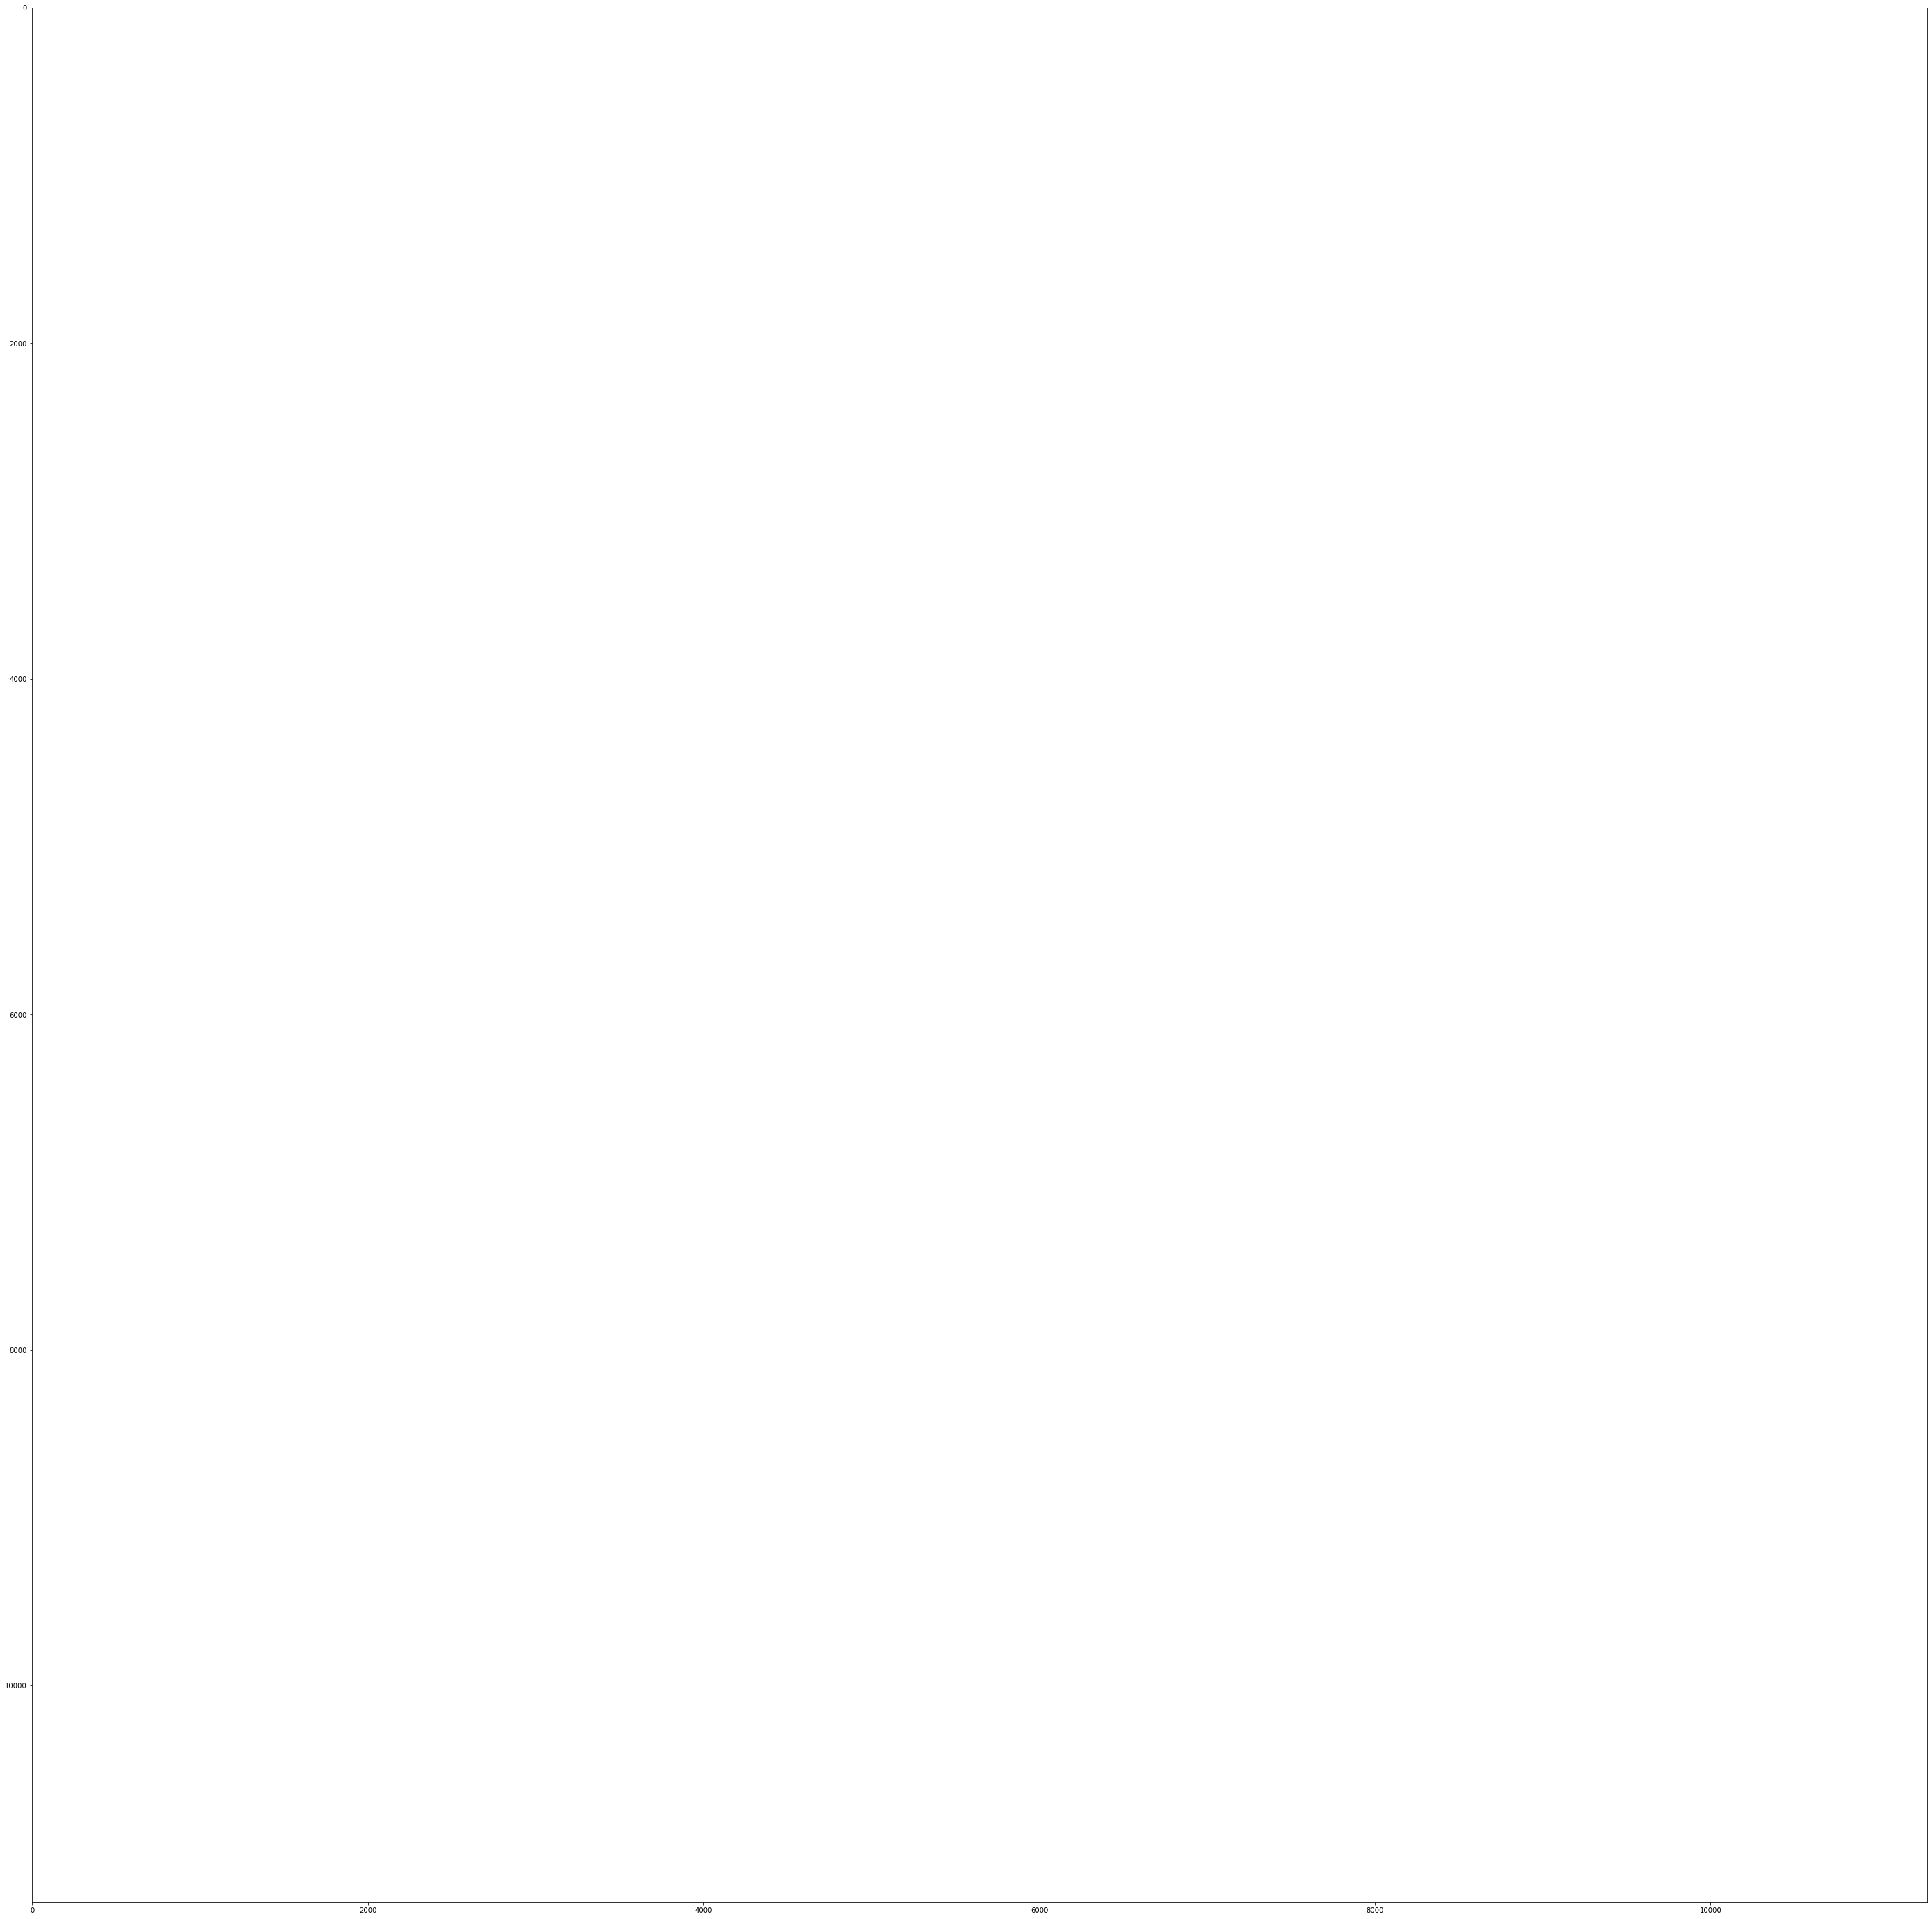

In [20]:
%%time
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(mean_dataset)

In [21]:
# del water_dataset
client.restart()

Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 40 Memory: 168.65 GB


**create binary water mask** based on summary product (based off likelihood of being persistent water bodies)

In [22]:
%%time
waterpres_prob = 0.5
T0_nd_water = np.isnan(mean_dataset)
T0_water = mean_dataset.where((mean_dataset < waterpres_prob) | (T0_nd_water == True), 1) # fix > prob to water
T0_water = T0_water.where((T0_water >= waterpres_prob) | (T0_nd_water == True), 0) # fix < prob to no water 

CPU times: user 1.63 s, sys: 1.4 s, total: 3.03 s
Wall time: 3.03 s


In [23]:
mean_dataset = None

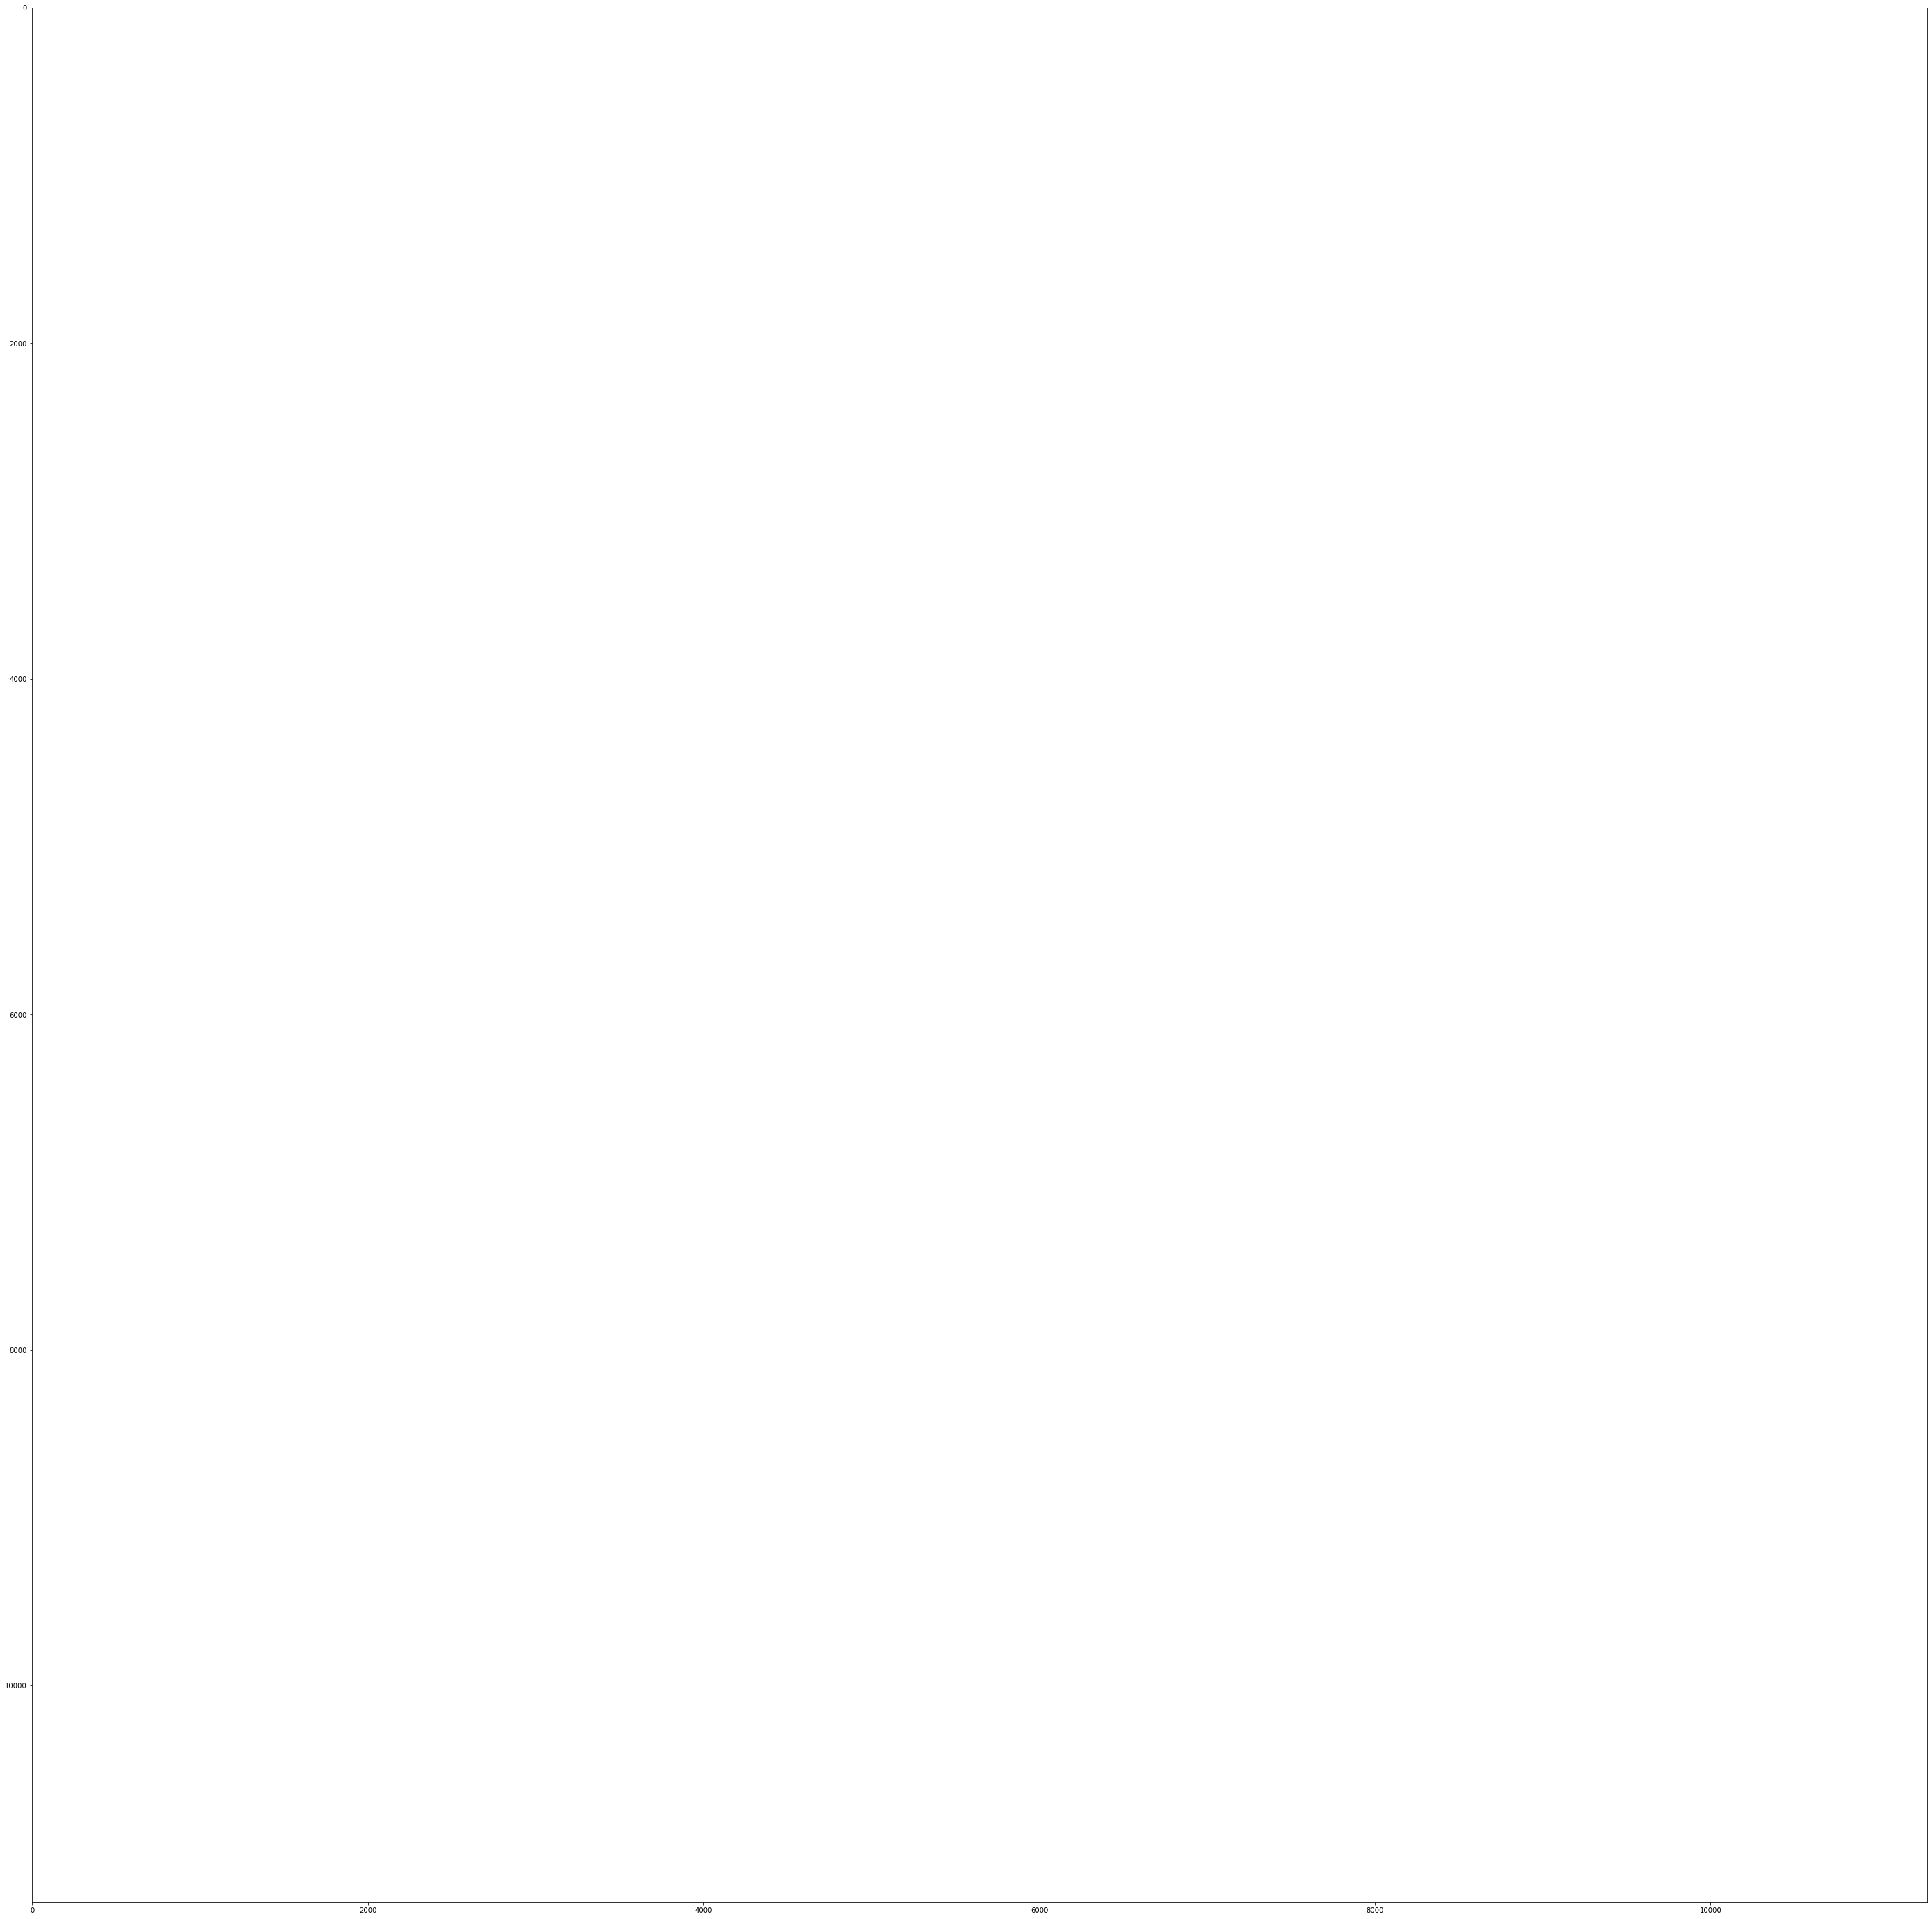

In [24]:
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(T0_water)

# **(2) load T1 image**

**load** l8

In [25]:
product = T1_prod
measurements = T1_measurements

T1_dataset = dc.load(
    product=product,
    time=T1, # 
    lat=latitude,
    lon=longitude,
    output_crs=output_crs,
    resolution=resolution,
    measurements = T1_measurements,
#     group_by='solar_day',
    dask_chunks={
        #'time': 1,
        'x': 1000,
        'y': 1000,
    }
)
T1_dataset

<xarray.Dataset>
Dimensions:               (time: 1, x: 11292, y: 11291)
Coordinates:
  * time                  (time) datetime64[ns] 2019-11-20T22:19:41
  * y                     (y) float64 7.902e+06 7.901e+06 ... 7.789e+06
  * x                     (x) float64 6.987e+05 6.988e+05 ... 8.117e+05
Data variables:
    green                 (time, y, x) uint16 dask.array<shape=(1, 11291, 11292), chunksize=(1, 1000, 1000)>
    red                   (time, y, x) uint16 dask.array<shape=(1, 11291, 11292), chunksize=(1, 1000, 1000)>
    blue                  (time, y, x) uint16 dask.array<shape=(1, 11291, 11292), chunksize=(1, 1000, 1000)>
    nir                   (time, y, x) uint16 dask.array<shape=(1, 11291, 11292), chunksize=(1, 1000, 1000)>
    swir1                 (time, y, x) uint16 dask.array<shape=(1, 11291, 11292), chunksize=(1, 1000, 1000)>
    swir2                 (time, y, x) uint16 dask.array<shape=(1, 11291, 11292), chunksize=(1, 1000, 1000)>
    scene_classification  (time,

apply **clearsky mask** to image

In [26]:
# Identify pixels with valid data
if 'usgs' in product:
    good_quality = (
        (T1_dataset.pixel_qa == 322)  | # clear
        (T1_dataset.pixel_qa == 386)  |
        (T1_dataset.pixel_qa == 834)  |
        (T1_dataset.pixel_qa == 898)  |
        (T1_dataset.pixel_qa == 1346) |
        (T1_dataset.pixel_qa == 324)  | # water
        (T1_dataset.pixel_qa == 388)  |
        (T1_dataset.pixel_qa == 836)  |
        (T1_dataset.pixel_qa == 900)  |
        (T1_dataset.pixel_qa == 1348)
    )
elif 's2_esa' in product:
    good_quality = (
        (T1_dataset.scene_classification == 2) | # mask in DARK_AREA_PIXELS
    #     (T1_dataset.scene_classification == 3) | # mask in CLOUD_SHADOWS
        (T1_dataset.scene_classification == 4) | # mask in VEGETATION
        (T1_dataset.scene_classification == 5) | # mask in NOT_VEGETATED
        (T1_dataset.scene_classification == 6) | # mask in WATER
        (T1_dataset.scene_classification == 7)   # mask in UNCLASSIFIED
    )
    
else:
    print('nope')

# Apply mask
T1_dataset = T1_dataset.where(good_quality)

In [27]:
shdf = salem.read_shapefile(buffer_path)

In [28]:
T1_dataset.attrs['pyproj_srs'] = str(T1_dataset.attrs['crs'])

In [29]:
T1_dataset = T1_dataset.salem.roi(shape=shdf, other=np.nan)
# T1_dataset = T1_dataset.where(T1_dataset!=0).astype(np.uint16)

In [30]:
T1_dataset

<xarray.Dataset>
Dimensions:               (time: 1, x: 11292, y: 11291)
Coordinates:
  * time                  (time) datetime64[ns] 2019-11-20T22:19:41
  * y                     (y) float64 7.902e+06 7.901e+06 ... 7.789e+06
  * x                     (x) float64 6.987e+05 6.988e+05 ... 8.117e+05
Data variables:
    green                 (time, y, x) float64 dask.array<shape=(1, 11291, 11292), chunksize=(1, 1000, 1000)>
    red                   (time, y, x) float64 dask.array<shape=(1, 11291, 11292), chunksize=(1, 1000, 1000)>
    blue                  (time, y, x) float64 dask.array<shape=(1, 11291, 11292), chunksize=(1, 1000, 1000)>
    nir                   (time, y, x) float64 dask.array<shape=(1, 11291, 11292), chunksize=(1, 1000, 1000)>
    swir1                 (time, y, x) float64 dask.array<shape=(1, 11291, 11292), chunksize=(1, 1000, 1000)>
    swir2                 (time, y, x) float64 dask.array<shape=(1, 11291, 11292), chunksize=(1, 1000, 1000)>
    scene_classification  

**isolate image**

In [31]:
T1_img = T1_dataset.isel(time = 0)

CPU times: user 4.88 s, sys: 4.66 s, total: 9.54 s
Wall time: 21.6 s


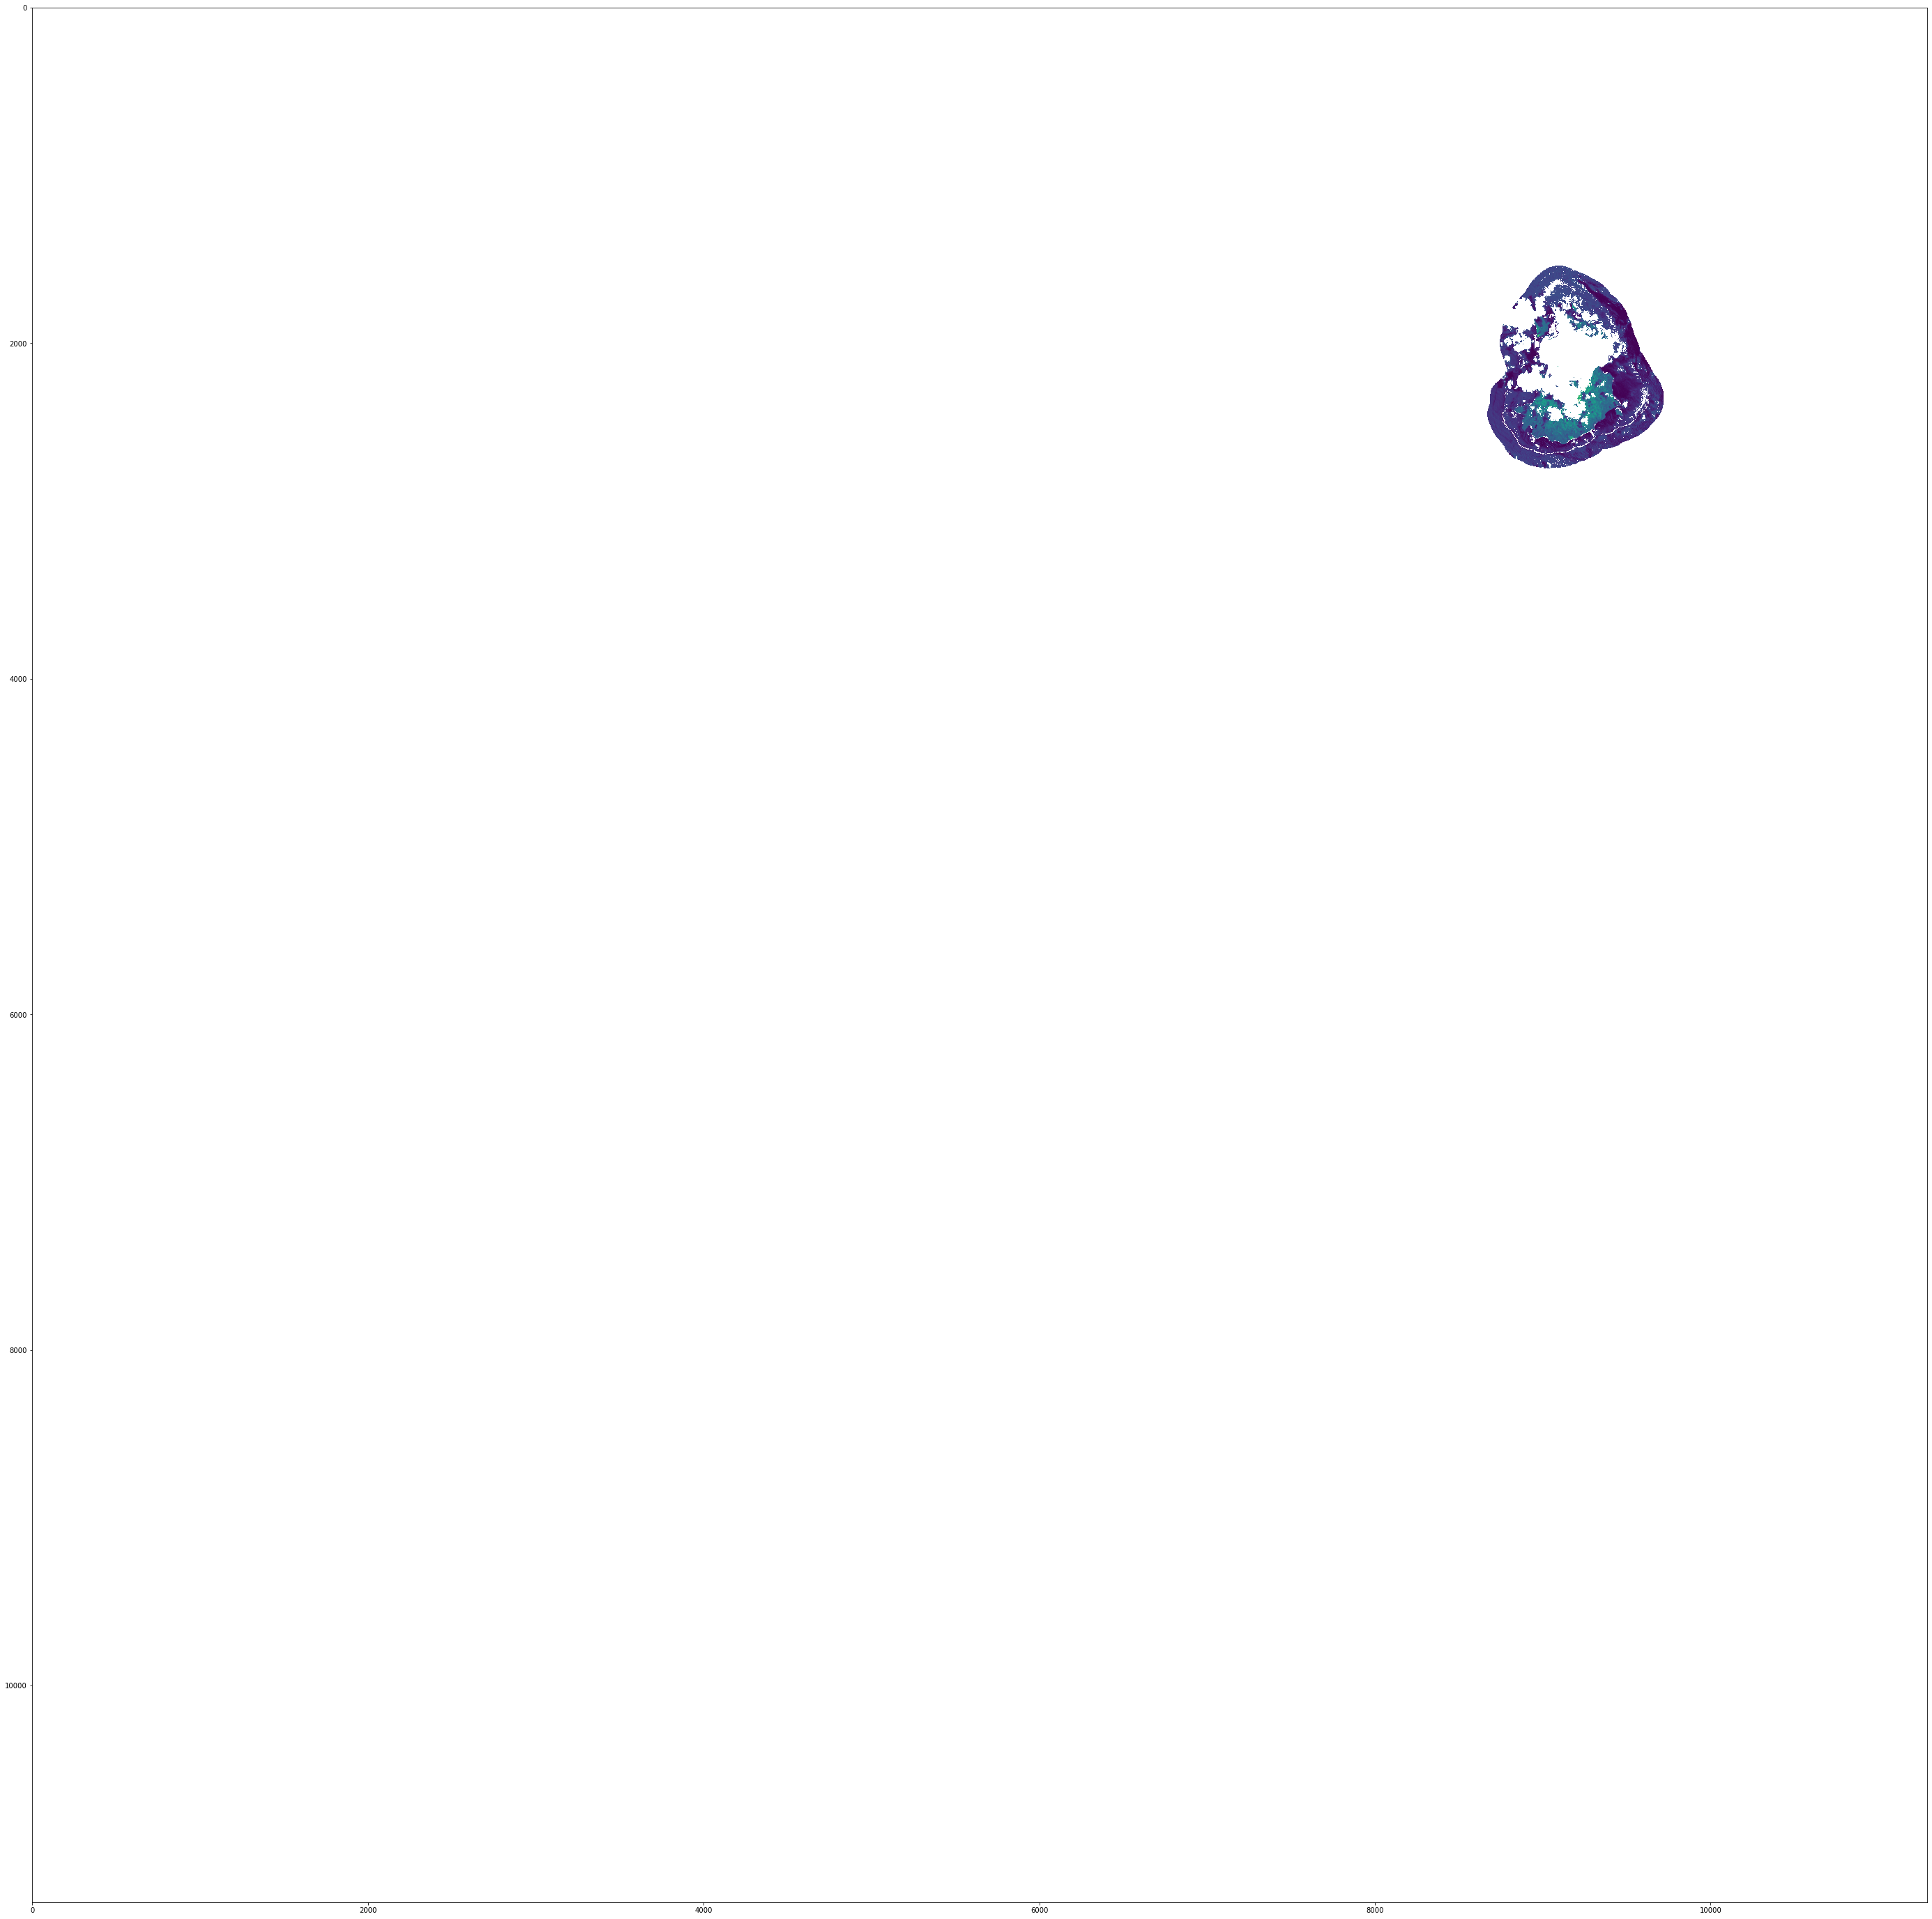

In [32]:
%%time
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(T1_img[ref_channel])

# **(3) Data prep**

## (3A) Training prep

**create outside merge of nodata** - T1 img + T0 water mask

In [33]:
%%time
# create mask
T0_nd_img = np.isnan(T1_img)[ref_channel]
T0_nd = T0_nd_water.where((T0_nd_img == False),True)

# apply mask
Ytrain = T0_water.where((T0_nd == False))
Xtrain = T1_img.where((T0_nd == False))

T0_nd_img = None
T0_nd = None

# fig, ax = plt.subplots(figsize=(50,50))
# ax.imshow(Ytrain)
# fig, ax = plt.subplots(figsize=(50,50))
# # ax.imshow(Xtrain.where(Xtrain[ref_channel]>0)[ref_channel])
# ax.imshow(Xtrain[ref_channel])

CPU times: user 4.56 s, sys: 8.39 ms, total: 4.57 s
Wall time: 4.57 s


**numpify** T1 image data

In [34]:
%%time
des_vars = T1_vars

lenx, leny = np.shape(Xtrain[ref_channel]) # dims of each raster
dsvals = np.zeros([len(des_vars),lenx, leny]) #set up array based on shape of xr and no. des bands

for i, m in zip(np.arange(0,len(Xtrain.data_vars),1), Xtrain.variables): # loop through bands in xr
    print(i, m)
    if m in des_vars: # only want relevant channels
        vals = np.array(Xtrain[m].values) # extract only the reflectance values
        dsvals[i,:,:] = vals # append to 'master' ND array
# plt.imshow(dsvals[0,:,:])

0 green
1 red
2 blue
3 nir
4 swir1
5 swir2
6 scene_classification
CPU times: user 29.9 s, sys: 26.6 s, total: 56.4 s
Wall time: 2min 29s


**re-shape**/flatten T1 data + T0 labels

In [35]:
Xtrain = dsvals.reshape(dsvals.shape[0], lenx * leny)  # reshape into nbands x 1D arrays
Ytrain = Ytrain.values.flatten()
dsvals = None

Xtrain.shape, Ytrain.shape

((6, 127497972), (127497972,))

**remove coincident nd from arrays** variables

In [36]:
Xtrain = np.array([i[~np.isnan(i)] for i in Xtrain])
Ytrain = Ytrain[~np.isnan(Ytrain)]

Xtrain.shape, Ytrain.shape

((6, 0), (0,))

**transpose** variables

In [37]:
Xtrain = Xtrain.transpose()  # transpose so that bands are read as features

Xtrain.shape, Ytrain.shape

((0, 6), (0,))

In [38]:
Xtrain.nbytes/1000000000, Ytrain.nbytes/1000000000

(0.0, 0.0)

# **(5) Training of T1 using T0 labels**

define **model params**

In [39]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=9, 
                               bootstrap = True,
                               max_features = 'sqrt',
                               max_depth=5,
                               n_jobs=3,
                               verbose=2
                              )

**fit model**

In [40]:
%%time
rf = model.fit(Xtrain, Ytrain)

ValueError: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required.

**score model on training set** - should be replaced with cross-validation

In [41]:
rf_score = rf.score(Xtrain, Ytrain)
rf_score

NameError: name 'rf' is not defined

In [ ]:
Xtrain = None
Ytrain = None

extract & plot **variable importances**

In [ ]:
importances = rf.feature_importances_

indices = np.argsort(importances)
features = [i for i in T1_img]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

extract and **plot decision tree** - TBC

## (3C) Inference Implementation Prep

**numpify** T1 image data - within merge

In [ ]:
%%time
des_vars = ['green','red','blue','nir','swir1','swir2']

lenx, leny = np.shape(T1_img[ref_channel]) # dims of each raster
dsvals = np.zeros([len(des_vars),lenx, leny]) #set up array based on shape of xr and no. des bands

for i, m in zip(np.arange(0,len(T1_img.data_vars),1), T1_img.variables): # loop through bands in xr
    print(i, m)
    if m in des_vars: # only want relevant channels
        vals = np.array(T1_img[m].values) # extract only the reflectance values
        dsvals[i,:,:] = vals # append to 'master' ND array
# plt.imshow(dsvals[0,:,:])

**re-shape**/flatten T1 data + T1 labels

In [ ]:
Ximp = dsvals.reshape(dsvals.shape[0], lenx * leny)  # reshape into nbands x 1D arrays
dsvals = None

Ximp.shape

**replace coincident nd from arrays** variables

**transpose** variables

In [ ]:
Ximp = Ximp.transpose()  # transpose so that bands are read as features

Ximp.shape

In [ ]:
foundnans = np.isnan(Ximp)
Ximp[foundnans] = 0

In [ ]:
Ximp.nbytes/1000000000

# **(6) Implement on full T1 image**

In [ ]:
predicted = rf.predict(Ximp)
predicted = np.array(predicted)

In [ ]:
predicted = predicted
predicted[foundnans[:,0]] = -9999
predicted = predicted.astype(np.int16)
predicted = np.reshape(predicted, [lenx, leny])
predicted_ds = T1_dataset
predicted_ds['water_mask'] = (('y','x'), predicted)
predicted = predicted_ds[['water_mask']]
predicted_ds = None

In [ ]:
probability = rf.predict_proba(Ximp)[:, 1]
probability = np.array(probability)

make dataset again

In [ ]:
probability = probability*100
probability[foundnans[:,0]] = -9999
probability = probability.astype(np.int16)
probability = np.reshape(probability, [lenx, leny])
probability_ds = T1_dataset
probability_ds['water_prob'] = (('y','x'), probability)
probability = probability_ds[['water_prob']]
probability_ds = None

In [ ]:
shdf = salem.read_shapefile(buffer_path)
predicted.attrs['pyproj_srs'] = str(predicted.attrs['crs'])
predicted = predicted.salem.roi(shape=shdf, other=1)

In [ ]:
shdf = salem.read_shapefile(buffer_path)
probability.attrs['pyproj_srs'] = str(probability.attrs['crs'])
probability = probability.salem.roi(shape=shdf, other=100)

In [ ]:
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(predicted.water_mask.where(predicted.water_mask>=0))
ax.set_title('Inferred Water Mask')
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(probability.water_prob.where(probability.water_prob>=0))
ax.set_title('Inferred Water Probability')
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(T1_img.swir1)
ax.set_title('SWIR1 Channel');

# **(7) Export(s)**

In [ ]:
from utils_dcal.data_cube_utilities.import_export import export_xarray_to_geotiff
import os

In [ ]:
# export stuff
inter_dir = '/home/jovyan/ml_outputs/water_products/'
scene_nm = original_metadata.uris[0].split('/')[-2] # assumes scenename as dir of indexed metadata 
local_prodir = inter_dir + scene_nm + '/'
os.makedirs(local_prodir, exist_ok=True)
out_mask_prod = local_prodir + scene_nm + '_watermask.tif'
out_prob_prod = local_prodir + scene_nm + '_waterprob.tif'

scene_nm, local_prodir, out_mask_prod, out_prob_prod

In [ ]:
%%time
export_xarray_to_geotiff(predicted, out_mask_prod, bands=['water_mask'], crs="EPSG:3460", x_coord='x', y_coord='y', no_data=-9999)

In [ ]:
%%time
export_xarray_to_geotiff(probability, out_prob_prod, bands=['water_prob'], crs="EPSG:3460", x_coord='x', y_coord='y', no_data=-9999)